In [3]:
%load_ext autoreload
%autoreload 1

In [21]:
# Familiar imports
import numpy as np
import pandas as pd

# For ordinal encoding categorical variables, splitting data
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# For training random forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import os
from os import path
import random
# import zipfile
import tqdm
%aimport common
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from datetime import datetime
import itertools
import json
import functools
from sklearn.feature_selection import mutual_info_regression

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans

FN = path.join(os.getcwd(),"20210818-30-days-ml-feature-eng.ipynb")

In [3]:
if not path.isfile(".data/30-days-of-ml.zip"):
    os.system("kaggle competitions download -c 30-days-of-ml")
if not path.isdir(".data/30-days-of-ml/"):
    os.system("unzip .data/30-days-of-ml.zip -d .data/30-days-of-ml")

In [4]:
# Load the training data
train = pd.read_csv(".data/30-days-of-ml/train.csv", index_col=0)
test = pd.read_csv(".data/30-days-of-ml/test.csv", index_col=0)

# Preview the data
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,B,B,A,A,B,D,A,F,A,O,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,A,A,A,C,B,D,A,D,A,F,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,B,B,A,C,B,D,A,E,C,K,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,A,A,A,C,B,D,A,E,A,N,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [6]:
# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# ordinal-encode categorical columns
X = features.copy()
X_test = test.copy()
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

## cross-entropy

In [8]:
%%time
def make_mi_scores(X, y, discrete_features="auto"):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

make_mi_scores(X,y)

CPU times: user 1min 23s, sys: 1e+03 ms, total: 1min 24s
Wall time: 1min 24s


cont12    0.021699
cont10    0.018486
cont9     0.012104
cont2     0.009703
cont7     0.009526
cont4     0.008801
cont8     0.008054
cat5      0.007765
cont0     0.007357
cat8      0.006473
cont6     0.005716
cont11    0.005455
cont3     0.004985
cat1      0.004282
cont5     0.003953
cont13    0.001485
cat9      0.001398
cat0      0.001324
cont1     0.001251
cat7      0.000838
cat3      0.000352
cat4      0.000180
cat6      0.000040
cat2      0.000000
Name: MI Scores, dtype: float64

👆 all features have low cross-entropy (cf. https://www.kaggle.com/ryanholbrook/mutual-information, no one is more than 1)

## range separation for discrete features

In [14]:
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [16]:
pd.DataFrame([
    {"cn":cn, "nunique_t":train[cn].nunique(),"nunique_v":test[cn].nunique()}
    for cn
    in train
    if cn.startswith("cat")
]).sort_values(by="nunique_t")

,cn,nunique_t,nunique_v
0,cat0,2,2
1,cat1,2,2
2,cat2,2,2
3,cat3,4,4
4,cat4,4,4
5,cat5,4,4
8,cat8,7,7
6,cat6,8,8
7,cat7,8,8
9,cat9,15,15


,cat9,mean,std
0,A,8.235361,0.757966
1,B,8.240704,0.751706
2,C,8.221689,0.735681
3,D,8.222303,0.767380
4,E,8.278238,0.782296
5,F,8.259045,0.737937
6,G,8.233879,0.744216
7,H,8.240703,0.756633
8,I,8.223861,0.749777
9,J,8.230406,0.746705


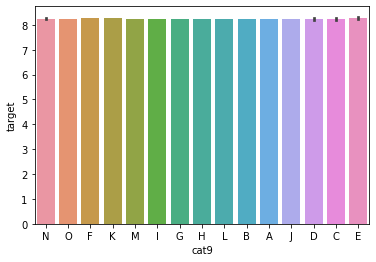

In [27]:
cn = "cat9"
sns.barplot(data=train,x=cn,y="target")
_AGG = {"mean":np.mean,"std":np.std}
pd.DataFrame([{cn:idx,**{k:v(slice_.target) for k,v in _AGG.items()}}for idx,slice_ in train.groupby(cn)]).sort_values(by=cn)

👆no clear separation for any of categorical features

## discrete/continuous interplay

In [31]:
_AGG = {
    **{k:getattr(np,k) for k in "mean,min,max".split(",")},
    "var_coeff":lambda v:np.std(v)/np.mean(v),
}
pd.DataFrame([
    {
        "discrete_features":df,
        "continuous_feature":cf,
        **{
            f"corr_{k}":v([np.corrcoef(slice_[cf],slice_.target)[0,1] for idx,slice_ in train.groupby(df)])
            for k,v
            in _AGG.items()
        }
    }
    for df,cf
    in tqdm.tqdm_notebook( list(itertools.product(
        filter(lambda fn:fn.startswith("cat"),list(train)), 
        filter(lambda fn:fn.startswith("cont"),list(train)),
    )))
]).sort_values(by="corr_mean",ascending=False)

/var/folders/ct/g3vlqxnn3gsbhhvrmpwt2kj80000gn/T/ipykernel_60728/2635640016.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm.tqdm_notebook( list(itertools.product(


  0%|          | 0/140 [00:00<?, ?it/s]

,discrete_features,continuous_feature,corr_mean,corr_min,corr_max,corr_var_coeff
108,cat7,cont10,0.095875,0.004130,0.303502,1.049127
103,cat7,cont5,0.088048,-0.055951,0.367276,1.818614
54,cat3,cont12,0.081749,0.054855,0.125174,0.354401
105,cat7,cont7,0.078263,-0.048629,0.297071,1.598533
110,cat7,cont12,0.077634,-0.138083,0.426255,1.994164
...,...,...,...,...,...,...
111,cat7,cont13,-0.055360,-0.235212,0.006514,-1.273957
93,cat6,cont9,-0.059767,-0.168434,-0.005547,-1.048531
69,cat4,cont13,-0.061336,-0.122586,-0.027646,-0.600412
99,cat7,cont1,-0.073490,-0.515150,0.009145,-2.283986


👆 still no love :(

## establish baseline

In [23]:
X,y,X_test = common.setup()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [7]:
%%time
baseline = common.score_dataset(X,y)
baseline

CPU times: user 19min 56s, sys: 10.8 s, total: 20min 6s
Wall time: 2min 52s


0.7243932677236726

### PCA

In [17]:
from sklearn.decomposition import PCA

PCA_FEATURES = [
    "cont10",
    "cont12",
    "cont9",
    "cont2",
]

X_scaled = X.loc[:,PCA_FEATURES]
X_scaled = (X_scaled-X_scaled.mean(axis=0))/ X_scaled.std(axis=0)
X_scaled;

<AxesSubplot:xlabel='cont12', ylabel='cont10'>

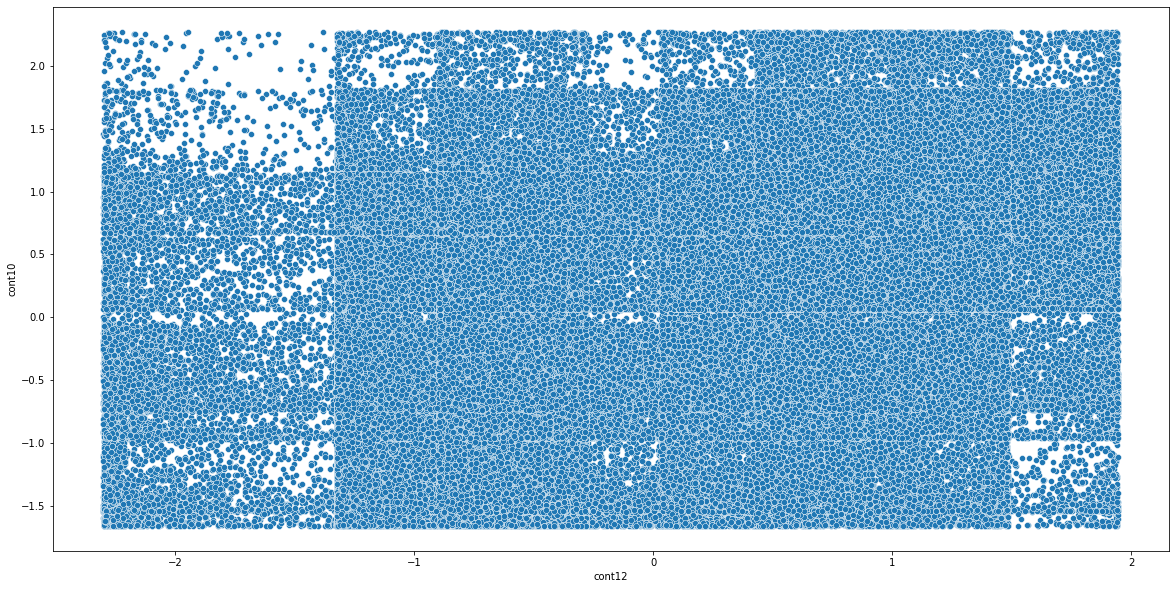

In [33]:
plt.subplots(figsize=(20,10))
sns.scatterplot(data=X_scaled,y="cont10",x="cont12")

In [34]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca)
X_pca

pca.components_.T

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

In [18]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
pca_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ("pca",PCA())
])


categorical_features = [cn for cn in X if cn.startswith("cat")]
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [cn for cn in X if cn.startswith("cont") and cn not in PCA_FEATURES]),
        ('pca', pca_transformer, PCA_FEATURES),
        ('cat', "passthrough", [cn for cn in X if cn.startswith("cat")])
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgboost.XGBRegressor()),
    ]
)

common.score_dataset(X,y,model=clf,baseline=baseline)

(0.7351971806951639, 'not good')

## scaling

In [16]:
numeric_features = [cn for cn in X if cn.startswith("cont")]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [cn for cn in X if cn.startswith("cat")]
# categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', "passthrough", categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgboost.XGBRegressor()),
    ]
)

# mse = -cross_val_score(clf,scf(X),y,cv=5,scoring="neg_mean_squared_error").mean()
# mse
# X
# pd.DataFrame(data=clf.fit_transform(X),columns=list(X))
common.score_dataset(X,y,model=clf,baseline=baseline)

(0.7241766170836205, 'good')

## clustering

In [30]:
numeric_features = [cn for cn in X if cn.startswith("cont")]
IMPORTANT_FEATURES = [
    "cont10",
    "cont12",
    "cont9",
    "cont2",
]


# KMeans(n_cl)
ppl1 = Pipeline(
    steps = [
        ("'preproc",ColumnTransformer(transformers=[
            ("important",StandardScaler(),IMPORTANT_FEATURES), 
            ("drop","drop",[cn for cn in X if cn not in IMPORTANT_FEATURES])
        ])),
        ("kmeans",KMeans()),
        ("xgb",xgboost.XGBRegressor())
    ]
)
# pd.DataFrame(ppl.fit_transform(X_train))
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_features = [cn for cn in X if cn.startswith("cat")]
# # categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', "passthrough", categorical_features),
#     ]
# )

# # Append classifier to preprocessing pipeline.
# # Now we have a full prediction pipeline.
# clf = Pipeline(
#     steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', xgboost.XGBRegressor()),
#     ]
# )

# common.score_dataset(X,y,model=clf,baseline=baseline)

,0,1,2,3,4,5,6,7
0,3.699542,0.699889,2.636997,2.466258,1.826939,1.903492,3.899431,3.134999
1,2.601271,4.171783,2.926374,3.222515,2.566160,3.398692,1.859218,1.638641
2,3.300214,2.092846,2.643569,3.113032,3.348759,1.974974,4.293810,2.590427
3,0.835146,4.273176,1.974224,2.334583,3.415580,3.642883,1.490949,2.330807
4,3.686992,1.895354,3.407862,2.486705,2.392399,0.918770,4.153456,2.876821
...,...,...,...,...,...,...,...,...
224995,2.791942,3.950132,3.153218,2.405399,1.961409,3.209434,1.756220,2.567265
224996,1.688256,3.156622,1.800329,1.772765,3.423358,2.760232,3.015555,2.730891
224997,1.197573,4.421135,2.589366,2.053583,3.236259,3.499729,1.319574,2.428882
224998,1.503715,3.263931,1.302455,2.031220,3.326881,3.073080,2.657380,2.587559


In [32]:
numeric_features = [cn for cn in X if cn.startswith("cont")]
IMPORTANT_FEATURES = [
    "cont10",
    "cont12",
    "cont9",
    "cont2",
]


# KMeans(n_cl)
ppl = Pipeline(
    steps = [
        ("'preproc",ColumnTransformer(transformers=[
            ("important",StandardScaler(),IMPORTANT_FEATURES), 
            ("drop","drop",[cn for cn in X if cn not in IMPORTANT_FEATURES])
        ])),
        ("kmeans",KMeans()),
#         ("xgb",xgboost.XGBRegressor())
    ]
)
pd.DataFrame(ppl.fit_transform(X))
common.score_dataset(pd.DataFrame({**X, "cluster":list(ppl.fit_predict(X))}),y,baseline=baseline)

(0.7245860668747827, 'not good')

In [43]:
numeric_features = [cn for cn in X if cn.startswith("cont")]
IMPORTANT_FEATURES = [
    "cont10",
    "cont12",
    "cont9",
    "cont2",
]


# KMeans(n_cl)
ppl = Pipeline(
    steps = [
        ("'preproc",ColumnTransformer(transformers=[
            ("important",StandardScaler(),IMPORTANT_FEATURES), 
            ("drop","drop",[cn for cn in X if cn not in IMPORTANT_FEATURES])
        ])),
        ("kmeans",KMeans()),
#         ("xgb",xgboost.XGBRegressor())
    ]
)
# pd.DataFrame(ppl.fit_transform(X))
# pd.DataFrame({**X, **pd.DataFrame(data=ppl.fit_transform(X))})
cluster_distances = ppl.fit_transform(X)
common.score_dataset(pd.DataFrame({
    **X, **{f"cd_{i}":list(cluster_distances[:,i]) for i in range(cluster_distances.shape[1])},
}),y,baseline=baseline)

(0.72502557921416, 'not good')

## target encoding